In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import math

In [8]:
#FSCS

def point_operator(ima,n,m,p,l):
    J = np.zeros((n,m))
    for i in range(0,n):
        for j in range(0,m):
            J[i][j] = round(p*ima[i][j]+l)
            if J[i][j] > 255:
                J[i][j] = 255
            if J[i][j] < 0:
                J[i][j] = 0
    J = J.astype(int)
    return J


def FSCS(ima,n,m):
    maxd = np.amax(ima)
    mind = np.amin(ima)
    p = float(255/float(maxd-mind))
    l = -float((255*mind)/float(maxd-mind))
    J = point_operator(ima,n,m,p,l)
    return J

(144, 176)


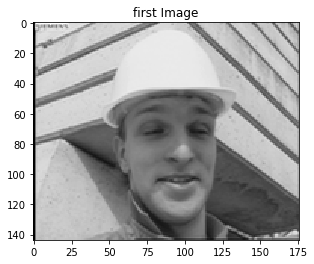

In [9]:
#Reading Images
first = mpimg.imread('first.png')
second = mpimg.imread('second.png')
first = FSCS(first,first.shape[0],first.shape[1])
second = FSCS(second,second.shape[0],second.shape[1])
plt.imshow(first,cmap="gray")
plt.title("first Image")
print(first.shape)

9 11


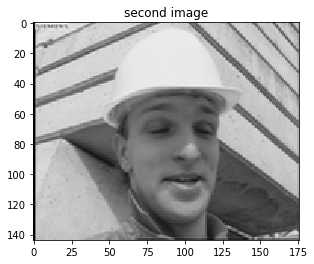

In [10]:
plt.imshow(second,cmap="gray")
plt.title("second image")
print(9,11)

### Question-1
#### Cost_in_MAD: returns cost wrt MAD metric
#### three_step_method: returns motion vector of dimension 9-11-2

In [11]:

def cost_in_MAD(block_1,block_2):
#     print(block_1.shape,block_2.shape)
    return np.mean(np.abs(block_1.astype(float)-block_2.astype(float)))


# To deal with corner cases easily i took left top element as reference since left-top and center points are constrained to be at same distance.
# we will keep 9*11 matrix(matrix of 16*16 blocks) in mind and find next position of each block and stored those values in 
# motion vectors array of shape 9*11*2 (*2 beacause to store x,y cords for each block )
def three_step_method(present_image,past_image):
    
    height,width = present_image.shape
#     motion_x = []
#     motion_y = []
    motion_vectors = np.zeros((int(height/16),int(width/16),2))
#     print(motion_vectors.shape)
    starting_step = 4
    
    i = 0
#     print(height-15,width-15)
    while i < height-15 :
        j = 0
        while j < width-15 :
#             print(i,j)
            x_cord = i
            y_cord = j
            
            next_x = x_cord
            next_y = y_cord
            present_cost = cost_in_MAD(present_image[i:i+16,j:j+16],past_image[i:i+16,j:j+16])
#             print(present_cost)
            step = starting_step
            while step >= 1 :
#                 print(step,i)
                ax = [-step,0,step]
                for m in ax:
                    for n in ax:
#                         print(m,n)
                        temp_x = next_x+m
                        temp_y = next_y+n
                        if ((temp_x >= 0 ) and ((temp_x + 16) < height) and ((temp_y >= 0) and ((temp_y+16) < width))):
#                             print(temp_x,temp_y)
                            new_cost = cost_in_MAD(present_image[i:i+16,j:j+16],past_image[temp_x:temp_x+16,temp_y:temp_y+16])
#                             print(present_cost,new_cost)
                            if new_cost < present_cost:
                                present_cost = new_cost
                                next_x = temp_x
                                next_y = temp_y
                step = int(step/2)
#             print(next_x,next_y)
#             motion_x.append(next_x-i)
#             motion_y.append(next_y-j)
            motion_vectors[int(i/16),int(j/16),:] = [next_x-i,next_y-j]
            j = j+16
        i = i + 16
    return motion_vectors

# In motion vector i have directions to best mactching block of frame-1 for frame 2's block 


### A: is motion_vectors array

In [12]:
A = three_step_method(second,first)

In [13]:
# step = 10
# ax = [-step,0,step]
# for i in ax:
#     print(i)

### Question-2
#### Motion vector plotted in matrix of 9 - 11 where each point indicates block of size 16*16

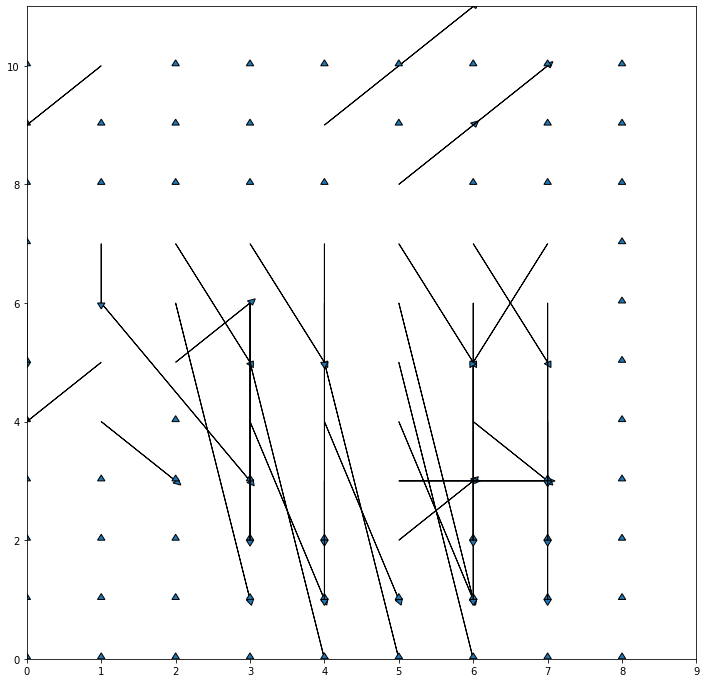

In [14]:
# Check below 2 boxes for Question-3 solution
plt.figure(figsize=(12,12))
plt.xlim(0,9)
plt.ylim(0,11)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        plt.arrow(i,j,A[i][j][0],A[i][j][1],
          head_width=0.1, head_length=0.1)
# A.shape
# the person looks turns his head to right if i am right motion vectors also says the same!


#### Motion vectors plotted in matrix of shape 176-144 (wrt to centers) 

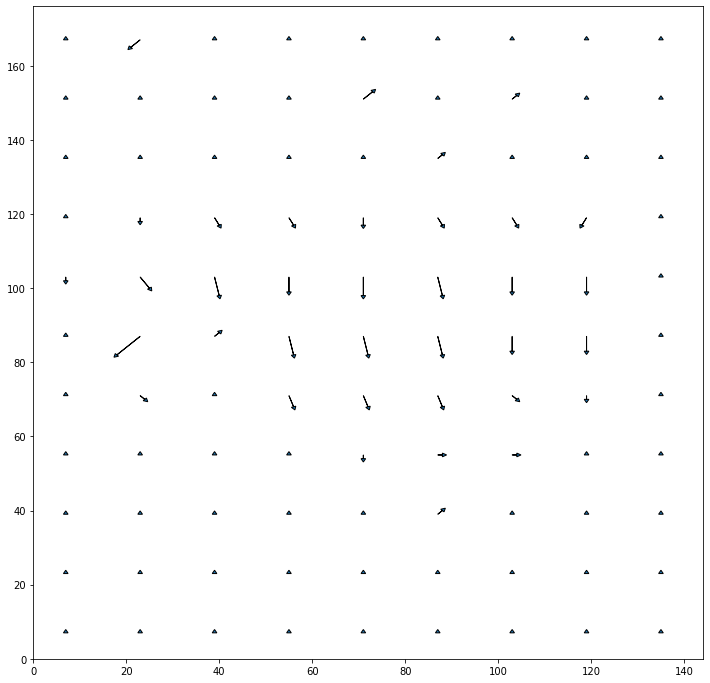

In [15]:
plt.figure(figsize=(12,12))
plt.xlim(0,144)
plt.ylim(0,176)
for i in range(7,144,16):
    for j in range(7,176,16):
#         print(int(i/16),int(j/16))
        plt.arrow(i,j,A[int(i/16)][int(j/16)][0],A[int(i/16)][int(j/16)][1],
          head_width=1, head_length=0.9)
    
# If i am right we have interprete the below plot's by placing mirror at bottom and taking transpose.so that output looks
# like matrix(like frame_1)

# Doing so we can see many arrows are pointing left,left_top meaning the next frames have blocks from left or
# left top that means the person is moving right ...which is true!!!(as we can see from frame 2)


### Question-3
#### Prediction frame k+1 from frame k

<h> Prediction_forward : takes frame-k , motion_vectors as input and outputs frame-(k+1) </h>

In [16]:
# Since motion vectors have directions to best mactching block of frame-1 for frame 2's block 

def prediction_forward(first,A):
    height,width = first.shape
#     print(height,width)
    new_frame = np.zeros((height,width))
    i = 0
    while i < height-15:
        j = 0
        while j < width-15:
            x = int(i/16)
            y = int(j/16)
#             print(x)
            temp_x = A[x,y,0]
            temp_y = A[x,y,1]
            
            next_x = i+temp_x
            next_y = j+temp_y
            
            next_x = next_x.astype(int)
            next_y = next_y.astype(int)
#             print(j)
#             Here i replaced a block with shifted block iff shifted block is in bounds else
#             i just copied same frame to next frame(otherwise i am getting black at edges)
            if (next_x > 0) and (next_x+16 < height) and (next_y > 0 ) and (next_y < width) :
                new_frame[i:i+16,j:j+16] = first[next_x:next_x+16,next_y:next_y+16]
            else:
                new_frame[i:i+16,j:j+16] = first[i:i+16,j:j+16]
    
            j += 16
        i += 16
    return new_frame

Text(0.5, 1.0, 'Predicted_frame_2')

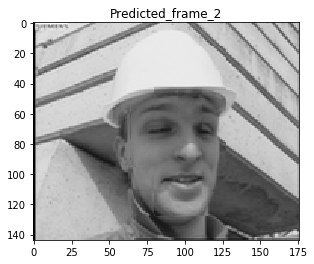

In [17]:
# Getting frame 2 using frame 1 

frame_2_predicted = prediction_forward(first,A)
plt.imshow(frame_2_predicted,cmap="gray")
plt.title("Predicted_frame_2")

### Question-4
#### Left plot is Original Image and right plot is predicted Image

Left is Original Image and Right is Predicted Image


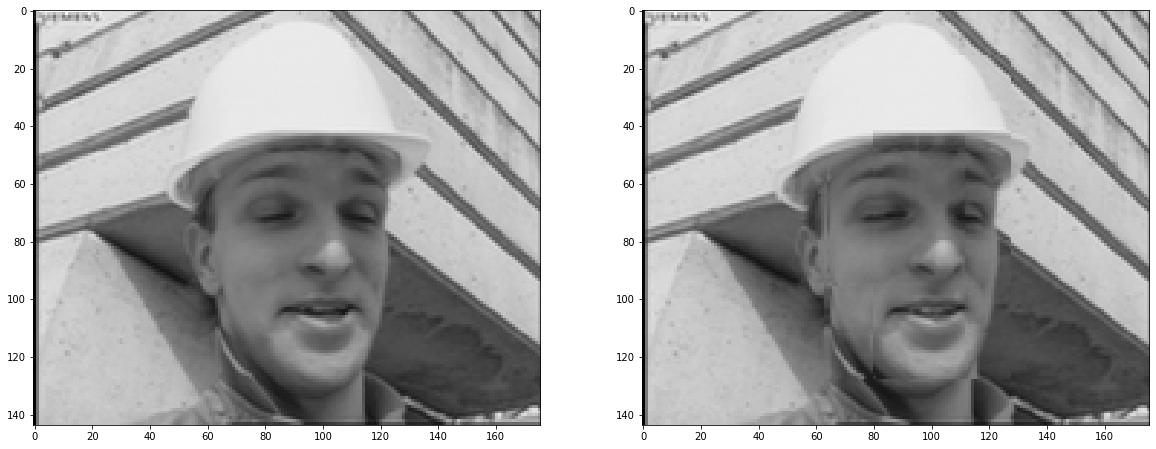

In [18]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# ax1.title("Orignal Frame 2")
ax1.imshow(second,cmap="gray")
# plt.title("predicted Frame 2")
ax2.imshow(frame_2_predicted,cmap="gray")
print("Left is Original Image","and","Right is Predicted Image")

In [19]:
error = cost_in_MAD(second,frame_2_predicted)
print("MAD_error between original frame 2 and Predicted frame 2 is: ",error)

MAD_error between original frame 2 and Predicted frame 2 is:  3.4895833333333335


In [20]:
print("MAD_error between frame 1 and frame 2 is: ",cost_in_MAD(first,second))
# my prediction is ok to consider since it is in-between frame-1 and frame-2

MAD_error between frame 1 and frame 2 is:  5.452020202020202


Text(0.5, 1.0, 'Frame 1')

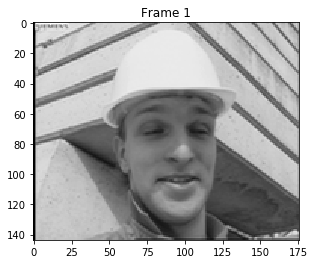

In [21]:
plt.imshow(first,cmap="gray")
plt.title("Frame 1")

In [22]:
#End

In [23]:
# i = 0
# ff = first
# while i < 3 :
#     x = prediction(ff,A)
#     ff = x
#     plt.imshow(ff,cmap="gray")
#     i += 1
# # 

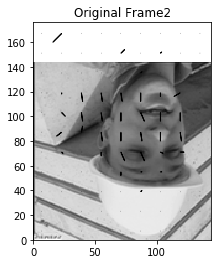

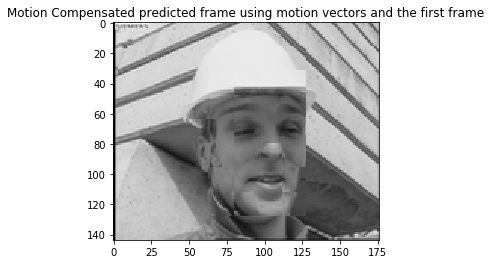

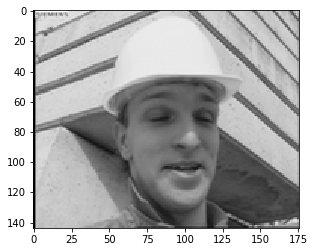

In [53]:
import numpy  as np
from  matplotlib import pyplot
import matplotlib.image as mpimg

def point_operator(ima,n,m,p,l):
    J = np.zeros((n,m))
    for i in range(0,n):
        for j in range(0,m):
            J[i][j] = round(p*ima[i][j]+l)
            if J[i][j] > 255:
                J[i][j] = 255
            if J[i][j] < 0:
                J[i][j] = 0
    J = J.astype(int)
    return J


def FSCS(ima,n,m):
    maxd = np.amax(ima)
    mind = np.amin(ima)
    p = float(255/float(maxd-mind))
    l = -float((255*mind)/float(maxd-mind))
    J = point_operator(ima,n,m,p,l)
    return J

first = mpimg.imread('first.png')
second = mpimg.imread('second.png')
frame1 = FSCS(first,first.shape[0],first.shape[1])
frame2 = FSCS(second,second.shape[0],second.shape[1])
plt.imshow(frame2,cmap="gray")
# plt.title("first Image")
# print(first.shape)

def MAD(arr1,arr2):
#   s=0
#   for i in range(-8,8):
#     for j in range(-8,8):
#         s=s+abs(arr2[a-i,b-j]-arr1[a-i+d1,b-j+d2])
#   return s/256
#     print(arr1)
#     print(arr2)
    return np.mean(np.abs(arr1.astype(float)-arr2.astype(float)))

def safe(i,j,n,m):            #checks whether the indices are safe or not
  if i-7>=0 and j-7>=0 and i+9<n and j+9<m:
    return True
  else:
    return False

def ss(frame1,frame2,d,i,j):  #this is implemented for 1 block of size 16*16
  n=frame1.shape[0]
  m=frame1.shape[1]
  i_1=i
  i_2=j
#   print(i_1,i_2) 
  diff=MAD(frame1[i-7:i+9,j-7:j+9],frame2[i-7:i+9,j-7:j+9])
  # diff=sys.maxsize                    #checks for all the adjacent 8 windows and itself
  if safe(i+d,j+d,n,m):
#     temp=MAD(frame1,d,d,frame2,i,j)
    temp=MAD(frame1[i-7+d:i+9+d,j-7+d:j+9+d],frame2[i-7:i+9,j-7:j+9])

    if diff>temp:                       #selects the minimum mad among the adjacent window
      diff=temp
      i_1=i+d
      i_2=j+d
  if safe(i-d,j-d,n,m):
#     temp=MAD(frame1,-d,-d,frame2,i,j)
    temp=MAD(frame1[i-7-d:i+9-d,j-7-d:j+9-d],frame2[i-7:i+9,j-7:j+9])

    if diff>temp:
      diff=temp
      i_1=i-d
      i_2=j-d
  if safe(i+d,j,n,m):
#     temp=MAD(frame1,d,0,frame2,i,j)
    temp=MAD(frame1[i-7+d:i+9+d,j-7:j+9],frame2[i-7:i+9,j-7:j+9])

    if diff>temp:
      diff=temp
      i_1=i+d
      i_2=j
  if safe(i-d,j,n,m):
#     temp=MAD(frame1,-d,0,frame2,i,j)
    temp=MAD(frame1[i-7-d:i+9-d,j-7:j+9],frame2[i-7:i+9,j-7:j+9])
    if diff>temp:
      diff=temp
      i_1=i-d
      i_2=j
  if safe(i,j+d,n,m):
#     temp=MAD(frame1,0,d,frame2,i,j)
    temp=MAD(frame1[i-7:i+9,j-7+d:j+9+d],frame2[i-7:i+9,j-7:j+9])
    if diff>temp:
      diff=temp
      i_1=i
      i_2=j+d
  if safe(i,j-d,n,m):
#     temp=MAD(frame1,0,-d,frame2,i,j)
    temp=MAD(frame1[i-7:i+9,j-7-d:j+9-d],frame2[i-7:i+9,j-7:j+9])
    if diff>temp:
      diff=temp
      i_1=i
      i_2=j-d
  if safe(i+d,j-d,n,m):
#     temp=MAD(frame1,d,-d,frame2,i,j)
    temp=MAD(frame1[i-7+d:i+9+d,j-7-d:j+9-d],frame2[i-7:i+9,j-7:j+9])
    if diff>temp:
      diff=temp
      i_1=i+d
      i_2=j-d
  if safe(i-d,j+d,n,m):
#     temp=MAD(frame1,-d,d,frame2,i,j)
    temp=MAD(frame1[i-7-d:i+9-d,j-7+d:j+9+d],frame2[i-7:i+9,j-7:j+9])
    if diff>temp:
      diff=temp
      i_1=i-d
      i_2=j+d
#     print(temp)
  return i_1,i_2                

dist_x=np.zeros((9,11),dtype=int)     #implements 3 step search for 9*11 blocks
dist_y=np.zeros((9,11),dtype=int)
for i in range(9):
  for j in range(11):
    dist_x[i][j],dist_y[i][j]=ss(frame1,frame2,4,16*i+7,16*j+7)
    dist_x[i][j],dist_y[i][j]=ss(frame1,frame2,2,dist_x[i][j],dist_y[i][j])
    dist_x[i][j],dist_y[i][j]=ss(frame1,frame2,1,dist_x[i][j],dist_y[i][j])
    
pyplot.xlim(0,144)            #Plots the motion vector at each macroblock
pyplot.ylim(0,176)
dx=np.zeros((9,11),dtype=int)
dy=np.zeros((9,11),dtype=int)
for i in range(9):
    for j in range(11):
      dx[i][j]=dist_x[i][j]-(16*i+7)
      dy[i][j]=dist_y[i][j]-(16*j+7)
      pyplot.arrow(16*i+7,16*j+7,dx[i][j],dy[i][j],head_width=0.09, head_length=0.002)

def issafe(i,j,arr):            #checks whether indices are safe or not
  if i>=0 and j>=0 and i<arr.shape[0] and j<arr.shape[1]:
    return True
  else:
    return False

temp=np.zeros((144,176))      #Generates frame 2 using frame 1 and motion vectors
for i in range(9):
  for j in range(11):
    if issafe(16*i+dx[i][j],16*j+dy[i][j],frame1) and issafe(16*(i+1)+dx[i][j],16*(j+1)+dy[i][j],frame1):
      temp[16*i:16*(i+1),16*j:16*(j+1)]=frame1[16*i+dx[i][j]:16*(i+1)+dx[i][j],16*j+dy[i][j]:16*(j+1)+dy[i][j]]
    else:
      temp[16*i:16*(i+1),16*j:16*(j+1)]=frame1[16*i:16*(i+1),16*j:16*(j+1)]

pyplot.imshow(frame2,cmap='gray')
pyplot.title("Original Frame2")
pyplot.show()
pyplot.imshow(temp,cmap='gray')
pyplot.title("Motion Compensated predicted frame using motion vectors and the first frame")
pyplot.show()
plt.imshow(frame2,cmap="gray")

In [56]:
i = 7
j = 7
frame1[i]
dx

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, -4,  3,  0,  0,  0, -7],
       [ 0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  1,  0,  3,  0],
       [ 0,  0,  1,  1,  3,  1,  3,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  3,  1,  0, -5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [57]:
MAD(frame2,temp)
dy

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1, -3, -3, -1,  0,  0, -7],
       [ 0,  0,  0,  0,  0,  5, -7, -7,  0,  0,  0],
       [ 0,  0,  0,  0, -3, -7, -7, -7,  0,  0,  0],
       [ 0,  0,  0, -3, -7, -7, -7, -7,  0,  3,  0],
       [ 0,  0,  1,  0, -7, -7, -7, -7,  1,  0,  0],
       [ 0,  0,  0,  0, -1, -7, -7, -3,  0,  1,  0],
       [ 0,  0,  0,  0,  0, -7, -7, -3,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [29]:
A

array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0., -1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1., -1.],
        [-5., -5.],
        [ 2., -3.],
        [ 0., -1.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-2., -2.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1.,  1.],
        [ 1., -5.],
        [ 1., -2.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1., -3.],
        [ 1., -5.],
        [ 0., -4.],
        [ 1., -2.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0., -1.],
        [ 1., -3.],
        [ 1.